In [1]:
!pip install facenet_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166

In [2]:
!pip install --upgrade Pillow
import os
import cv2

import torch
import torch.nn as nn
import numpy as np
import albumentations as A
from facenet_pytorch import MTCNN
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 11.0.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.3 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
ydata-profiling 4.12.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(keep_all=True, device=device)
mtcnn.eval()
model = deeplabv3_resnet101(pretrained=True).to(device)
model.eval()

def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img = cv2.imread(image_path)

    boxes, _ = mtcnn.detect(image)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            mask[y1:y2, x1:x2] = 255 

    black_background = img.copy()
    black_background[mask == 0] = [0, 0, 0]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((512, 512)),
    ])

    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    output_predictions = torch.argmax(output, dim=0).byte().cpu().numpy()

    face_mask = (output_predictions == 15).astype(np.uint8)

    if face_mask.shape != img.shape[:2]:
        face_mask = cv2.resize(face_mask, (img.shape[1], img.shape[0])) 

    face_mask_binary = (face_mask > 0).astype(np.uint8)
    result_refined = cv2.bitwise_and(img, img, mask=face_mask_binary)
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.cvtColor(result_refined, cv2.COLOR_BGR2RGB), face_mask_binary

def display_results(original, refined, mask):
    """
    Показывает три изображения в строке: исходное, обрезанное и маску.

    Args:
        original (ndarray): Исходное изображение.
        refined (ndarray): Обрезанное изображение с черным фоном.
        mask (ndarray): Маска (0, 1).
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(refined)
    plt.title("Refined Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 182MB/s]


In [4]:
img, result_refined, face_mask_binary = process_image('/kaggle/input/imdb-wiki-faces-dataset/imdb_crop/07/nm0000107_rm1223996160_1953-12-8_1987.jpg')

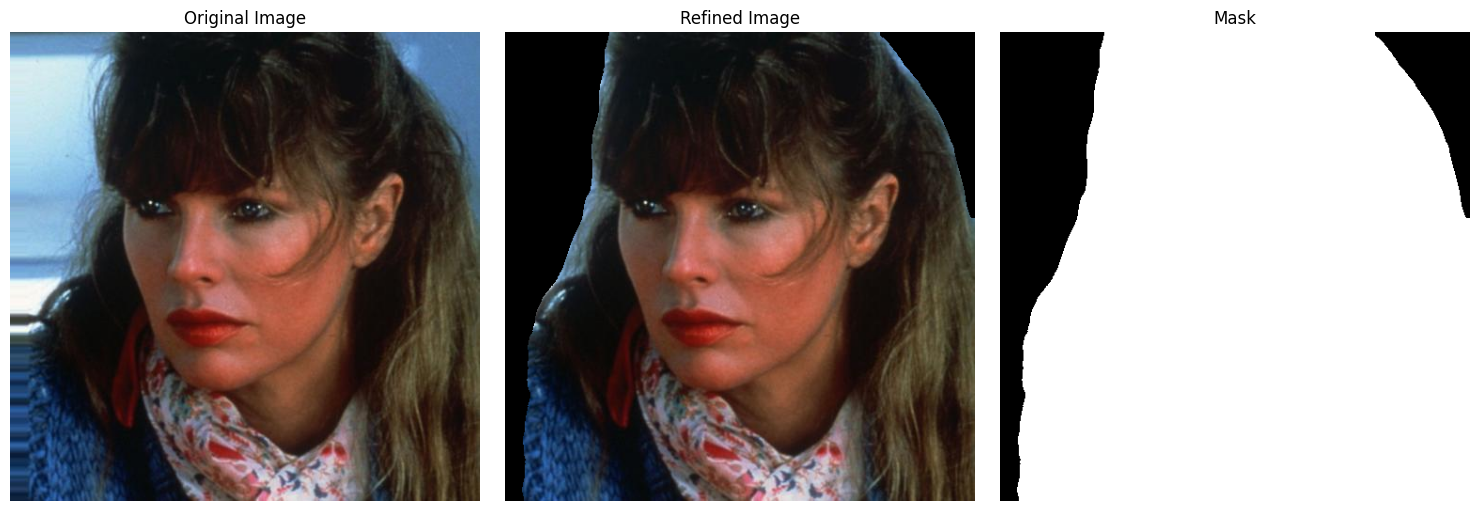

In [5]:
display_results(img, result_refined, face_mask_binary)

## Обучение

In [6]:
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.20
    Uninstalling albucore-0.0.20:
      Successfully uninstalled albucore-0.0.20
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.21
    Uninstalling albumentations-1.4.21:
      Successfully uninstalled albumentations-1.4.21


In [7]:
def get_paths(root_path):
    """
    Обходит все директории внутри заданного пути и возвращает список путей ко всем изображениям.

    Args:
        root_path (str): Корневая директория.

    Returns:
        np.ndarray: Массив путей ко всем изображениям.
    """
    images_paths = []

    for dirpath, _, filenames in os.walk(root_path):
        for filename in sorted(filenames):
            if filename.lower().endswith(('.jpg', '.jpeg')):
                images_paths.append(os.path.join(dirpath, filename))

    return np.stack(images_paths)


class FaceDataset(Dataset):
    def __init__(self, images, transform, augmentations, padded=False, normalize=False):
        self.image_paths = sorted(images) 
        self.transform = transform 
        self.augmentations = augmentations
        self.padded = padded
        self.normalize = None
        if normalize:
            self.normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        im_path = self.image_paths[idx]
        image, _, mask = process_image(im_path) 
        image = image / 255.0 
        mask = (mask > 0).astype(np.float32) 
    
        augmentation = np.random.choice(self.augmentations)
        if augmentation is None:
            augmented_image = image
            augmented_mask = mask
        else:
            augmented = augmentation(image=image, mask=mask)
            augmented_image = augmented['image']
            augmented_mask = augmented['mask']
    
        augmented_image = self.transform(augmented_image).float()
        augmented_mask = self.transform(augmented_mask).float()
        
        if self.normalize:
            augmented_image = self.normalize(augmented_image)
    
        return {
            'image': augmented_image,  
            'mask': augmented_mask  
        }

In [8]:
import scipy
import pandas as pd 
from datetime import datetime, timedelta
import bz2
mat_data = scipy.io.loadmat('/kaggle/input/imdb-info/imdb.mat')
dt = mat_data['imdb'][0, 0]

keys_s = ('gender', 'dob', 'photo_taken',
          'face_score', 'second_face_score', 'celeb_id')
values = {k: dt[k].squeeze() for k in keys_s}

keys_n = ('full_path', 'name')
for k in keys_n:
    values[k] = np.array([x if not x else x[0] for x in dt[k][0]])

# img(face_location(2):face_location(4),face_location(1):face_location(3),:))
values['face_location'] =\
    [tuple(x[0].tolist()) for x in dt['face_location'].squeeze()]

set_nrows = {len(v) for _, v in values.items()}
assert len(set_nrows) == 1

df_values = pd.DataFrame(values)

matlab_origin = datetime(1, 1, 1)  # MATLAB starts on January 1, year 1
days_offset = timedelta(days=366)

def matlab_datenum_to_datetime(datenum):
    try:
        if datenum > 0 and datenum < 3652059:  # 3652059 is approximately the year 9999 in MATLAB
            return matlab_origin + timedelta(days=datenum) - days_offset
        else:
            return pd.NaT 
    except OverflowError:
        return pd.NaT

df_values['dob'] = df_values['dob'].apply(matlab_datenum_to_datetime)
names = dt['celeb_names']
len([str(item[0]) for sublist in names for item in sublist])
len(np.unique(df_values['name'].values))
# Шаг 2: Фильтрация данных
filtered_df = df_values[
    (df_values['face_score'] > 0) & 
    (df_values['second_face_score'].isna())  # Убираем изображения с несколькими лицами
]

best_images = (
    filtered_df.sort_values(by=['face_score', 'photo_taken'], ascending=[False, False])
    .groupby('celeb_id')
    .first()
    .reset_index()
)
best_images = best_images.drop(columns=['second_face_score', 'celeb_id'])
image_paths = ["/kaggle/input/imdb-wiki-faces-dataset/imdb_crop/" + path for path in best_images['full_path']]
print(len(image_paths))

15495


In [9]:
def split_train_test(data, test_size=0.2, random_state=42):
    if random_state:
        np.random.seed(random_state)
    indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return data[train_indices], data[test_indices]


X_train, X_test = split_train_test(np.array(image_paths), test_size=0.2)

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(), transforms.Resize((512, 512))])

augmentation = [
            None,
            A.HorizontalFlip(p=1),        
            A.Rotate(limit=5, p=1),                                        
            A.VerticalFlip(p=1),                        
            A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1.0)]    

In [11]:
dataset = FaceDataset(
    images=X_train,
    transform=transform,
    augmentations=augmentation,
    padded=True, normalize=True
)

In [12]:
def show_example(dataset, idx):
    sample = dataset[idx]
    image = sample['image']
    mask = sample['mask']

    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    plt.axis('off') 
    plt.subplot(1, 2, 2)
    plt.imshow(mask.permute(1, 2, 0), cmap='gray')
    plt.axis('off') 
    
    plt.show()

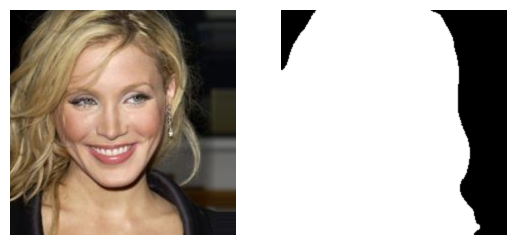

In [13]:
show_example(dataset, 113)

In [14]:
print(f"Dataset length {len(dataset)}")

Dataset length 12396


In [15]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

def dice_loss(target, prediction, eps=1e-8):
    prediction = torch.sigmoid(prediction)
    intersection = torch.sum(target * prediction)
    total = torch.sum(target) + torch.sum(prediction)
    
    loss = 1 - (2 * intersection + eps) / (total + eps)
    return loss.mean()

### LinkNet architecture:
In LinkNet, the input of each encoder layer is also passed to the output of its corresponding decoder. See [paper](https://www.theobjects.com/dragonfly/dfhelp/Content/Resources/PDFs/linknet.pdf).

<img src="https://wiki.cloudfactory.com/media/pages/docs/mp-wiki/model-architectures/linknet/b19f6073bd-1684131960/linknet.webp">

In [16]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, groups=groups, bias=bias),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if stride > 1 else nn.Identity()

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv2(self.conv1(x))
        return nn.ReLU(inplace=True)(out + residual)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super().__init__()
        self.blocks = nn.Sequential(
            EncoderBlock(in_channels, out_channels, kernel_size, stride, padding, groups, bias),
            EncoderBlock(out_channels, out_channels, kernel_size, 1, padding, groups, bias)
        )

    def forward(self, x):
        return self.blocks(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        super().__init__()
        mid_channels = in_channels // 4
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(mid_channels, mid_channels, kernel_size, stride, padding, output_padding, bias=bias),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)
    
    
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.tp_conv1 = self._conv_transpose_block(64, 32)
        self.conv2 = self._conv_block(32)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, kernel_size=2, stride=2)

    def _conv_block(self, in_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
    
    def _conv_transpose_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.tp_conv2(self.conv2(self.tp_conv1(x)))
    
class LinkNet(nn.Module):
    def __init__(self, n_classes=1, pretrained=False):
        super().__init__()
        if pretrained:
            base = resnet.resnet18(pretrained=True)

            self.in_block = nn.Sequential(
                base.conv1,
                base.bn1,
                base.relu,
                base.maxpool
            )

            self.encoders = nn.ModuleList([base.layer1,
                                           base.layer2,
                                           base.layer3,
                                           base.layer4])
        else:
            self.in_block = nn.Sequential(
                nn.Conv2d(3, 64, 7, 2, 3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, 2, 1)
            )
            
            encoder_params = [
                (64, 64, 3, 1, 1),
                (64, 128, 3, 2, 1),
                (128, 256, 3, 2, 1),
                (256, 512, 3, 2, 1)
            ]

            self.encoders = nn.ModuleList([Encoder(*params) for params in encoder_params])
        
        decoder_params = [
            (64, 64, 3, 1, 1, 0),
            (128, 64, 3, 2, 1, 1),
            (256, 128, 3, 2, 1, 1),
            (512, 256, 3, 2, 1, 1)
        ]
        
        self.decoders = nn.ModuleList([Decoder(*params) for params in decoder_params])


        # Classifier
        self.final = Classifier(n_classes)


    def forward(self, x):
        # Initial block
        x = self.in_block(x)

        # Encoder blocks
        e1 = self.encoders[0](x)
        e2 = self.encoders[1](e1)
        e3 = self.encoders[2](e2)
        e4 = self.encoders[3](e3)

        # Decoder blocks
        d4 = e3 + self.decoders[3](e4)
        d3 = e2 + self.decoders[2](d4)
        d2 = e1 + self.decoders[1](d3)
        d1 = x + self.decoders[0](d2)

        return self.final(d1)

In [17]:
test_dataset = FaceDataset(
    images=X_test,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((512, 512))]), 
    augmentations=[None],
    padded=True, normalize=True
)

In [18]:
def save_checkpoint(model, optimizer, scheduler, epoch, metrics, save_path="/kaggle/working/checkpoints", file_name="model_checkpoint.pth"):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    save_dict = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "metrics": metrics
    }
    file_path = os.path.join(save_path, file_name)
    torch.save(save_dict, file_path)
    print(f"Checkpoint saved at {file_path}")

In [19]:
from tqdm import tqdm

def validate_model(model, val_loader):
    model.eval()
    val_loss = 0
    ious = []
    
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)
            
            outputs = model(images)
            loss = dice_loss(masks, outputs)
            val_loss += loss.item()
            
            iou = calc_iou(outputs.to('cpu').detach().numpy(), masks.to('cpu').numpy())
            ious.append(iou)
    
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = sum(ious) / len(ious)
    
    return {
            "val_loss": avg_val_loss,
            "val_iou": avg_iou
            }

import matplotlib.pyplot as plt

def show_example(model, val_loader, device):
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)
            
            outputs = model(images)
            predictions = (outputs > 0).float() 
            
            image = images[0]
            image = image.permute(1, 2, 0).to('cpu') * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            true_mask = masks[0].permute(1, 2, 0).to('cpu')
            pred_mask = predictions[0].permute(1, 2, 0).to('cpu')
            
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(image)
            ax[0].set_title("Input Image")
            ax[1].imshow(true_mask, cmap='gray')
            ax[1].set_title("True Mask")
            ax[2].imshow(pred_mask, cmap='gray')
            ax[2].set_title("Predicted Mask")
            plt.show()
            break


def train_model(model, train_loader, val_loader, optimizer, scheduler, n_epochs, save_path="/kaggle/working/checkpoints"):
    model.to(device)
    
    metrics = {
        "train_loss": [],
        "train_iou": [],
        "val_loss": [],
        "val_iou": []
    }
    
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0
        ious = []
        for batch in train_loader:
            optimizer.zero_grad()
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)
            
            outputs = model(images)
            loss = dice_loss(masks, outputs)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            iou = calc_iou(outputs.to('cpu').detach().numpy(), masks.to('cpu').numpy())
            ious.append(iou)
        scheduler.step()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = sum(ious) / len(ious)
        
        val_metrics = validate_model(model, val_loader)
        
        metrics["train_loss"].append(avg_train_loss)
        metrics["train_iou"].append(avg_train_iou)
        metrics["val_loss"].append(val_metrics["val_loss"])
        metrics["val_iou"].append(val_metrics["val_iou"])
        
        print(f'Epoch [{epoch+1}/{n_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train IoU: {avg_train_iou:.4f}, '
              f'Val Loss: {val_metrics["val_loss"]:.4f}, '
              f'Val IoU: {val_metrics["val_iou"]:.4f}')
        
        print(f'Example result after epoch {epoch+1}:')
        show_example(model, val_loader, device)

        save_checkpoint(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch + 1,
            metrics=metrics,
            save_path=save_path,
            file_name=f"model_epoch_{epoch+1}.pth"
        )
    
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=n_epochs,
        metrics=metrics,
        save_path=save_path,
        file_name="final_model_checkpoint.pth"
    )
    
    return model, metrics


In [20]:
val_loader = DataLoader(
    test_dataset,           
    batch_size=16,
    shuffle=False,
)

train_loader = DataLoader(
    dataset,           
    batch_size=16,
    shuffle=True,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 0.2555, Train IoU: 0.6811, Val Loss: 0.1766, Val IoU: 0.7625
Example result after epoch 1:


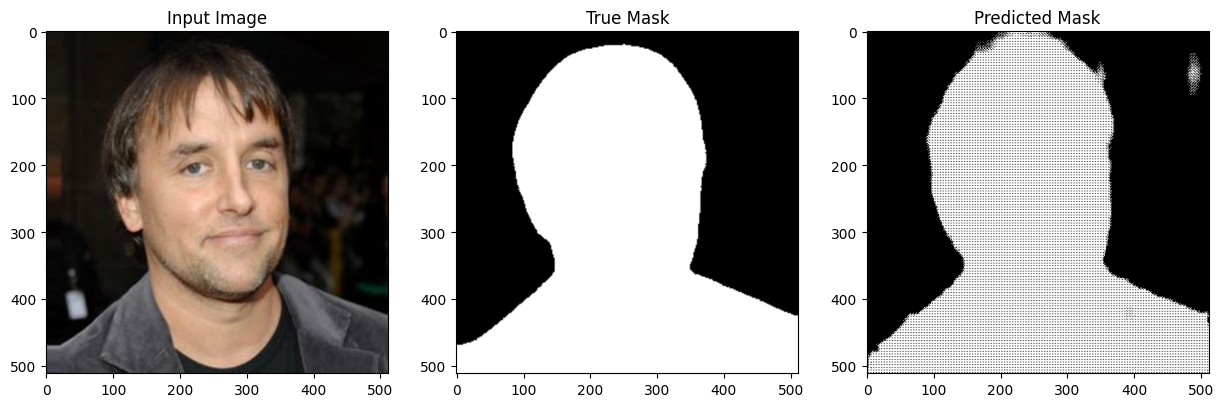

 20%|██        | 1/5 [44:14<2:56:56, 2654.01s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_1.pth
Epoch [2/5], Train Loss: 0.1491, Train IoU: 0.7971, Val Loss: 0.1102, Val IoU: 0.8365
Example result after epoch 2:


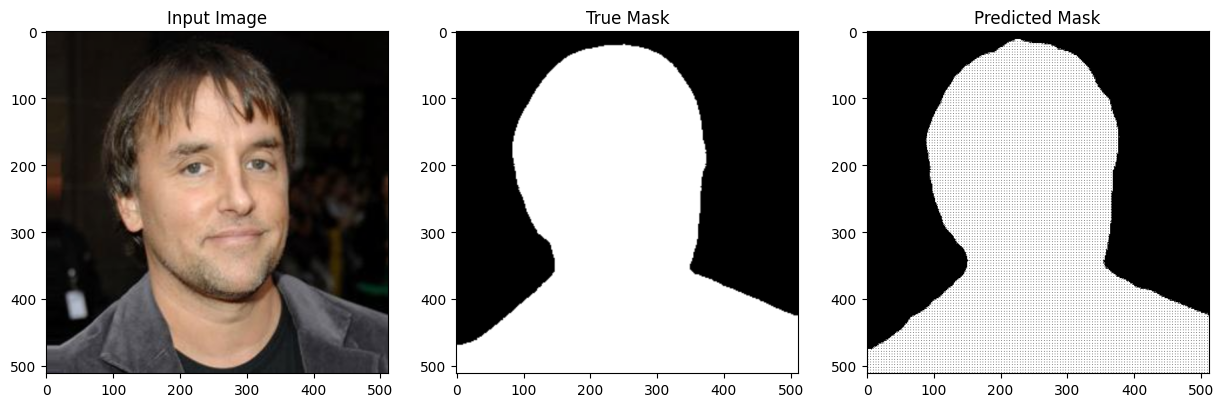

 40%|████      | 2/5 [1:28:24<2:12:35, 2651.99s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_2.pth
Epoch [3/5], Train Loss: 0.1075, Train IoU: 0.8216, Val Loss: 0.0847, Val IoU: 0.8875
Example result after epoch 3:


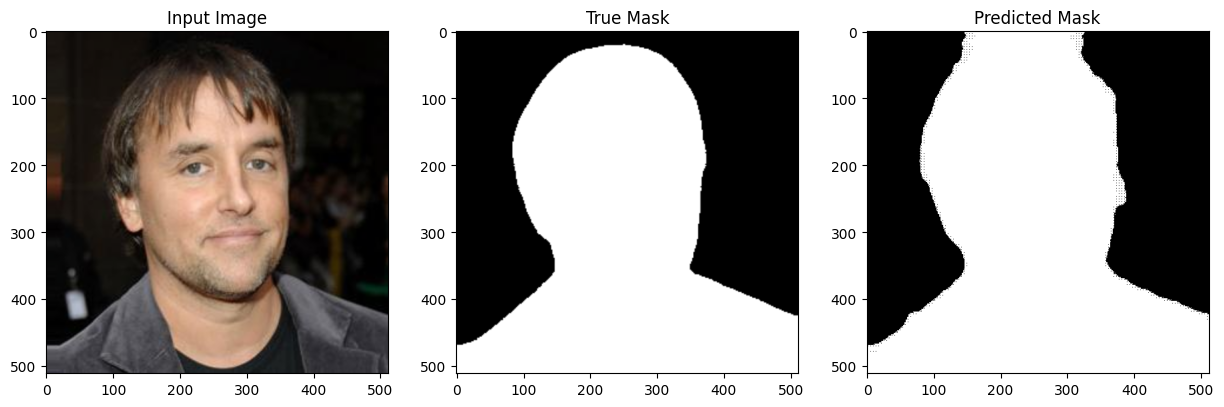

 60%|██████    | 3/5 [2:12:16<1:28:05, 2642.99s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_3.pth
Epoch [4/5], Train Loss: 0.0804, Train IoU: 0.8769, Val Loss: 0.0587, Val IoU: 0.9033
Example result after epoch 4:


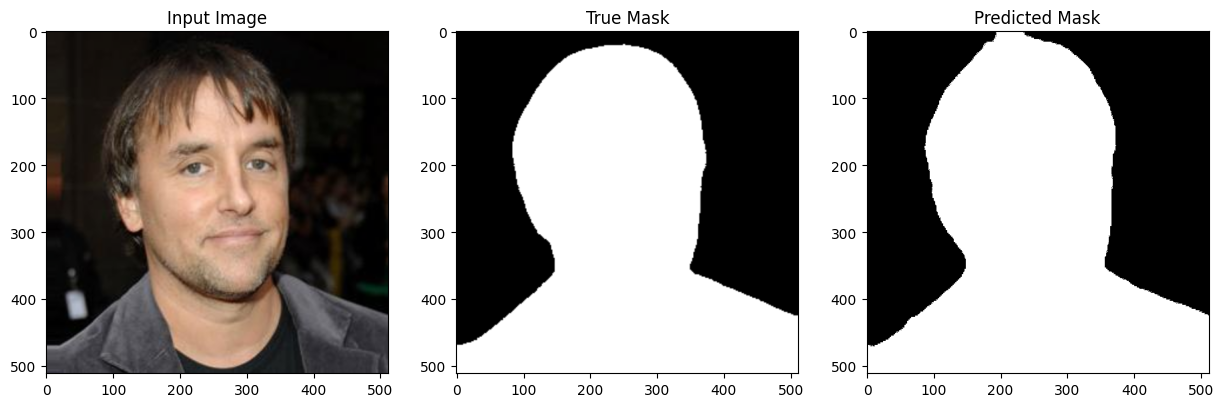

 80%|████████  | 4/5 [2:56:11<43:59, 2639.73s/it]  

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_4.pth
Epoch [5/5], Train Loss: 0.0691, Train IoU: 0.8813, Val Loss: 0.0531, Val IoU: 0.9068
Example result after epoch 5:


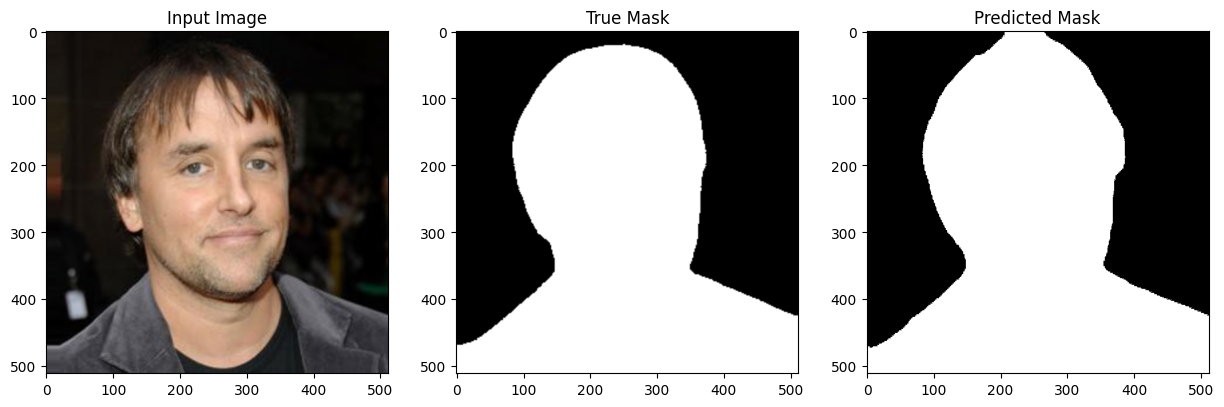

100%|██████████| 5/5 [3:40:10<00:00, 2642.07s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_5.pth


Checkpoint saved at /kaggle/working/checkpoints/final_model_checkpoint.pth


In [21]:
model_linknet = LinkNet()
optimizer = optim.AdamW(model_linknet.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
trained_model, metrics = train_model(model_linknet, train_loader, val_loader, optimizer, scheduler, n_epochs=5)

In [22]:
def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    plt.plot(metrics["train_loss"], label='Train Loss')
    plt.plot(metrics["val_loss"], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Dice Loss for scratch LinkNet')
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(metrics["val_iou"], label='Validation IoU', color='blue')
    plt.plot(metrics["train_iou"], label='Train IoU', color='orange')

    max_iou_idx = np.argmax(metrics["val_iou"])
    max_iou_value = metrics["val_iou"][max_iou_idx]
    plt.scatter(max_iou_idx, max_iou_value, color='green', zorder=5) 
    plt.text(max_iou_idx, max_iou_value, f'Max IoU: {max_iou_value:.2f}', 
             verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('IoU for scratch LinkNet')
    plt.grid()
    plt.show()


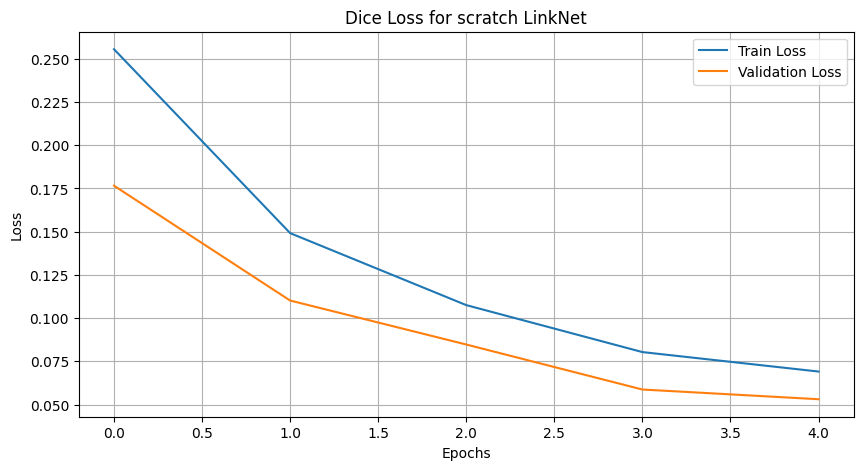

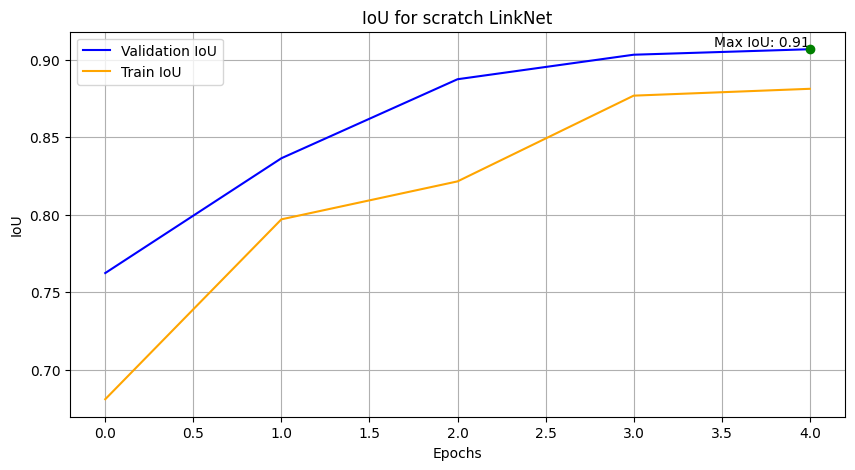

In [23]:
plot_metrics(metrics)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.9MB/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.1320, Train IoU: 0.8738, Val Loss: 0.0696, Val IoU: 0.9310
Example result after epoch 1:


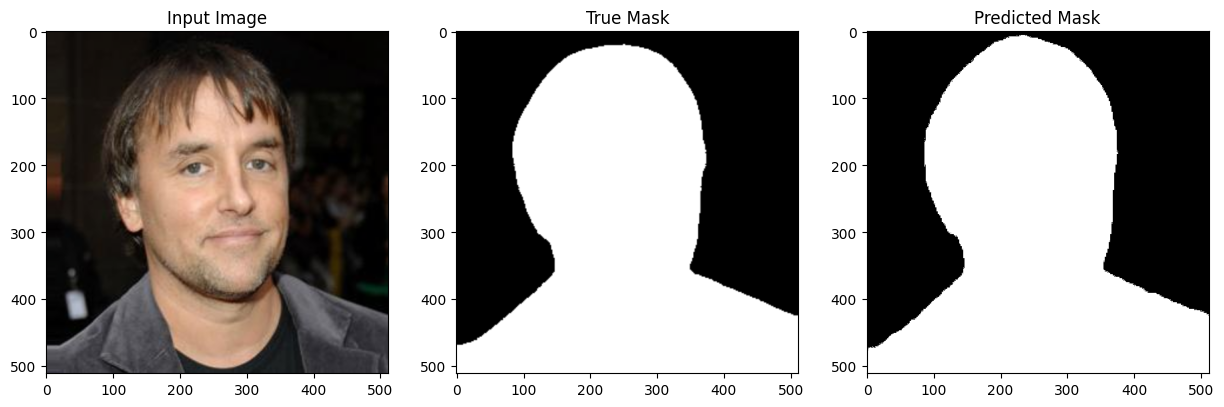

 10%|█         | 1/10 [43:44<6:33:38, 2624.26s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_1.pth
Epoch [2/10], Train Loss: 0.0687, Train IoU: 0.9107, Val Loss: 0.0488, Val IoU: 0.9311
Example result after epoch 2:


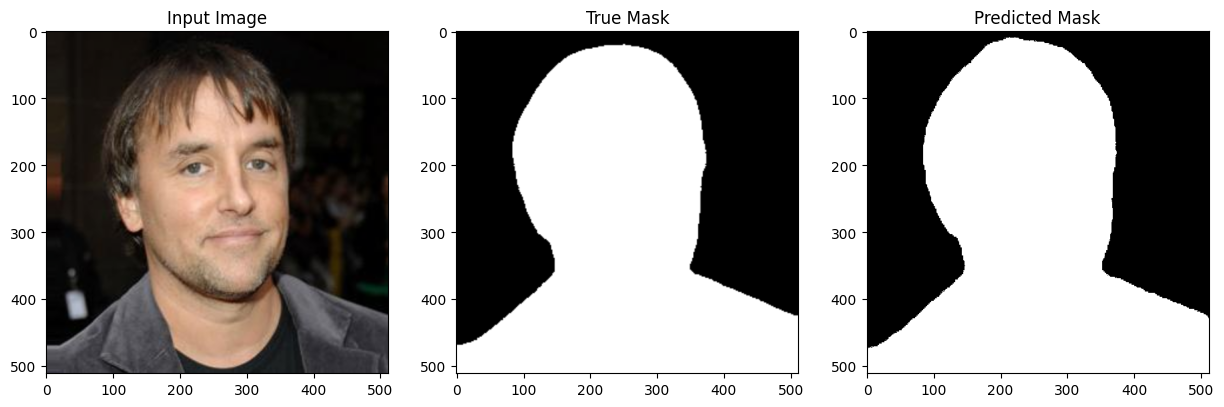

 20%|██        | 2/10 [1:27:20<5:49:18, 2619.79s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_2.pth
Epoch [3/10], Train Loss: 0.0541, Train IoU: 0.9153, Val Loss: 0.0417, Val IoU: 0.9311
Example result after epoch 3:


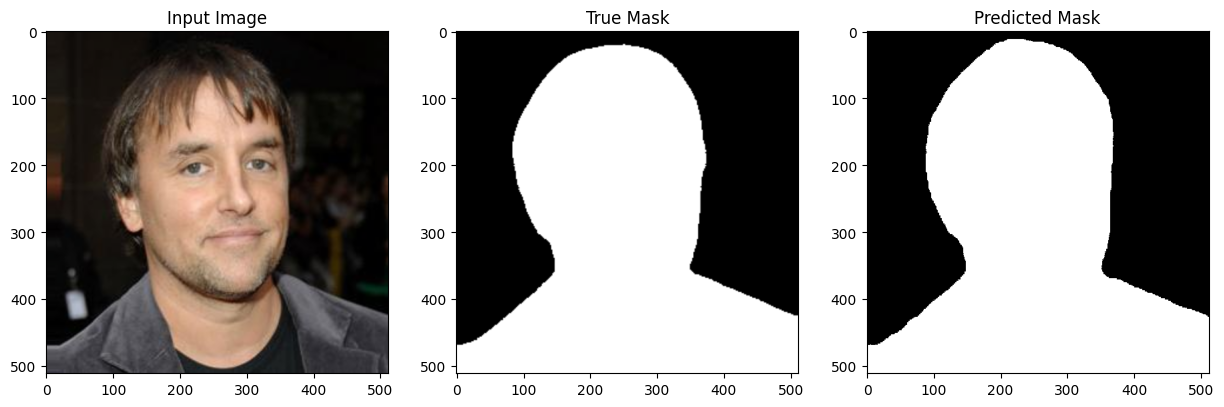

 30%|███       | 3/10 [2:11:11<5:06:11, 2624.53s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_3.pth
Epoch [4/10], Train Loss: 0.0472, Train IoU: 0.9194, Val Loss: 0.0376, Val IoU: 0.9344
Example result after epoch 4:


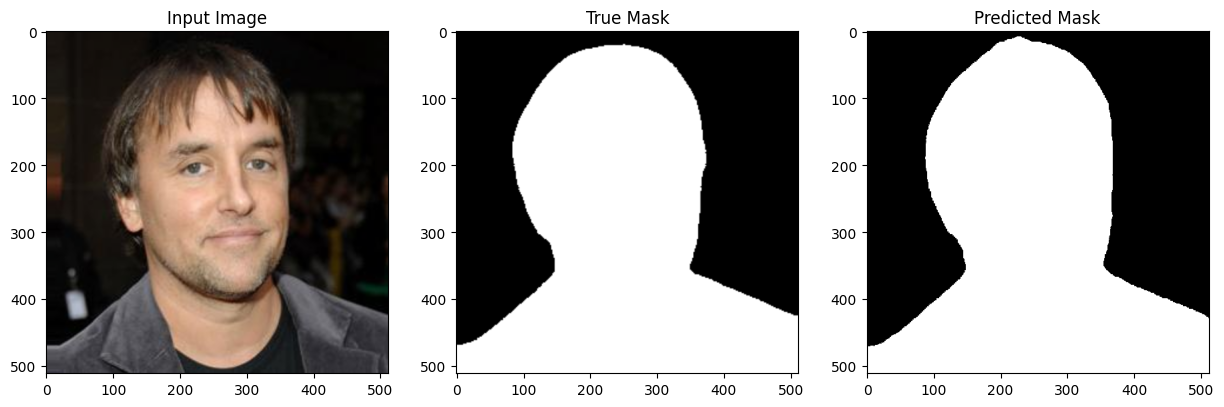

 40%|████      | 4/10 [2:54:52<4:22:20, 2623.49s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_4.pth
Epoch [5/10], Train Loss: 0.0437, Train IoU: 0.9218, Val Loss: 0.0351, Val IoU: 0.9354
Example result after epoch 5:


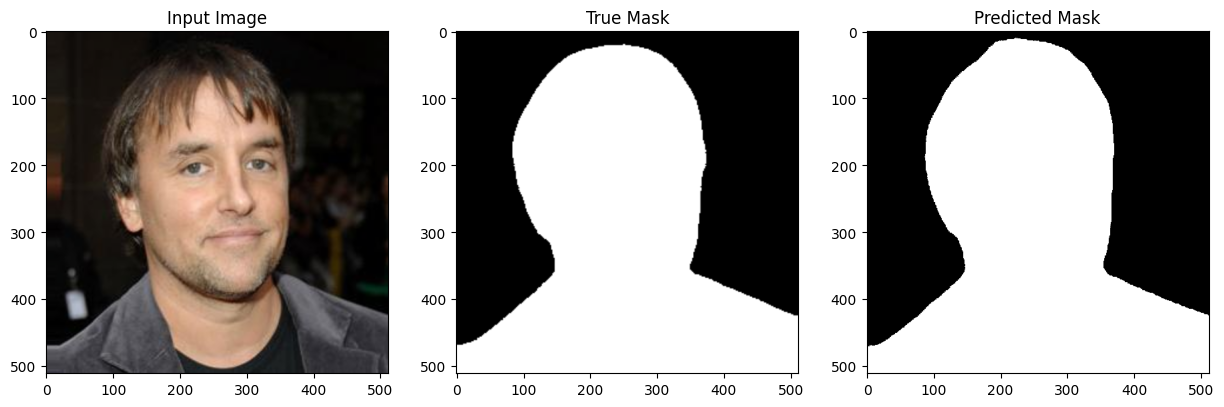

 50%|█████     | 5/10 [3:38:47<3:38:57, 2627.55s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_5.pth
Epoch [6/10], Train Loss: 0.0401, Train IoU: 0.9264, Val Loss: 0.0329, Val IoU: 0.9380
Example result after epoch 6:


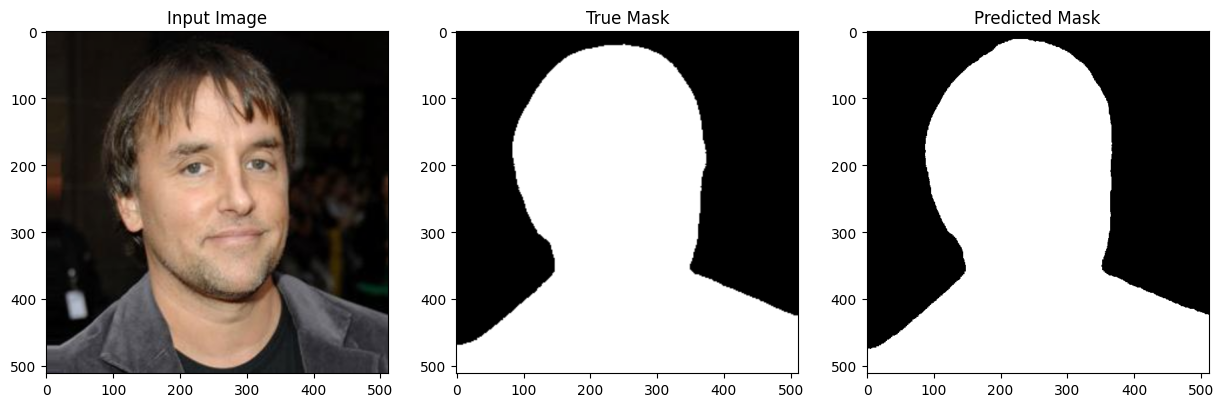

 60%|██████    | 6/10 [4:22:31<2:55:04, 2626.23s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_6.pth
Epoch [7/10], Train Loss: 0.0382, Train IoU: 0.9288, Val Loss: 0.0327, Val IoU: 0.9381
Example result after epoch 7:


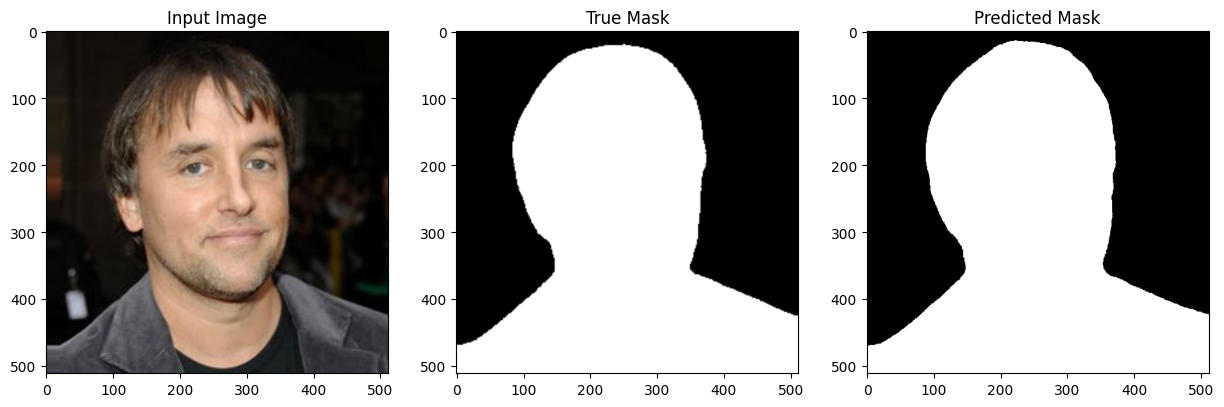

 70%|███████   | 7/10 [5:06:34<2:11:35, 2631.79s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_7.pth
Epoch [8/10], Train Loss: 0.0370, Train IoU: 0.9304, Val Loss: 0.0318, Val IoU: 0.9397
Example result after epoch 8:


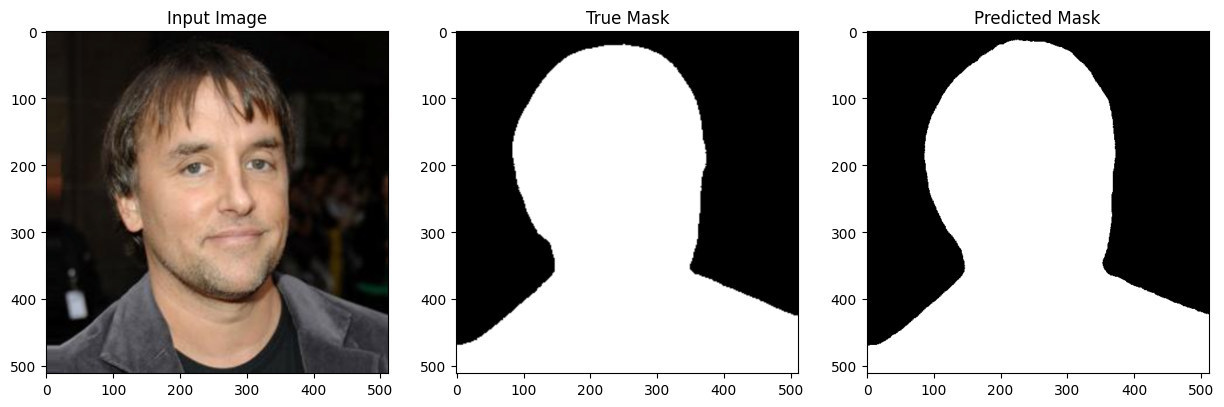

 80%|████████  | 8/10 [5:50:35<1:27:49, 2634.57s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_8.pth
Epoch [9/10], Train Loss: 0.0371, Train IoU: 0.9298, Val Loss: 0.0325, Val IoU: 0.9376
Example result after epoch 9:


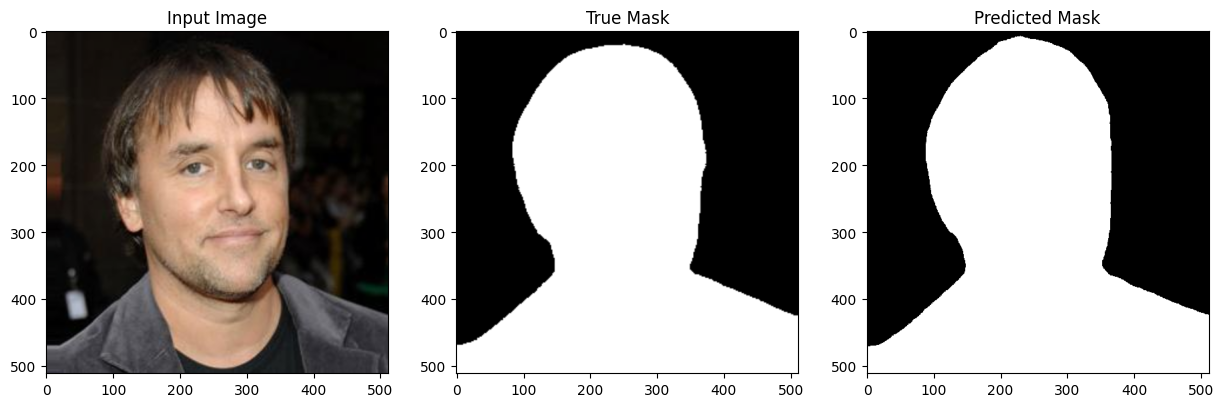

 90%|█████████ | 9/10 [6:34:20<43:51, 2631.79s/it]  

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_9.pth
Epoch [10/10], Train Loss: 0.0360, Train IoU: 0.9314, Val Loss: 0.0315, Val IoU: 0.9389
Example result after epoch 10:


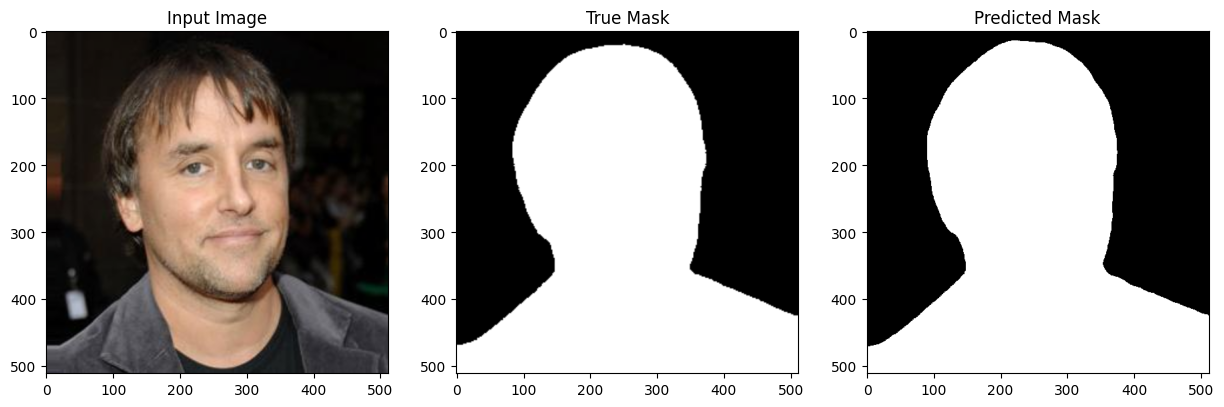

100%|██████████| 10/10 [7:18:14<00:00, 2629.42s/it]

Checkpoint saved at /kaggle/working/checkpoints/model_epoch_10.pth


Checkpoint saved at /kaggle/working/checkpoints/final_model_checkpoint.pth


In [24]:
model_linknet = LinkNet(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.AdamW(model_linknet.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
trained_model, metrics = train_model(model_linknet, train_loader, val_loader, optimizer, scheduler, n_epochs=10)

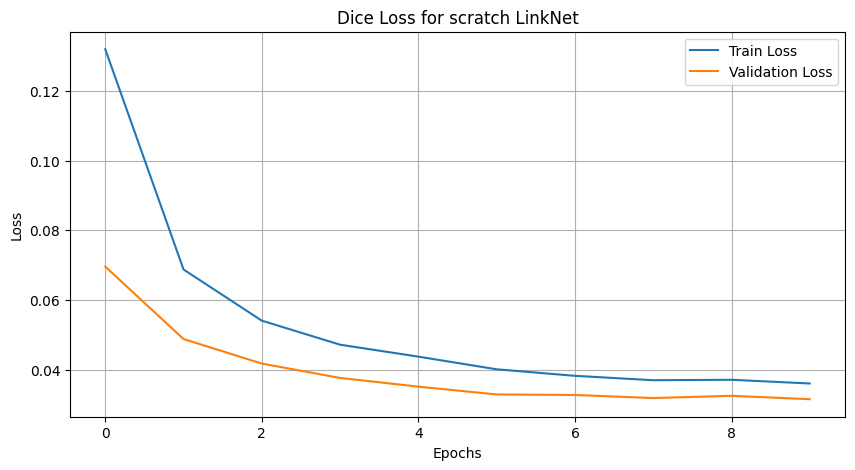

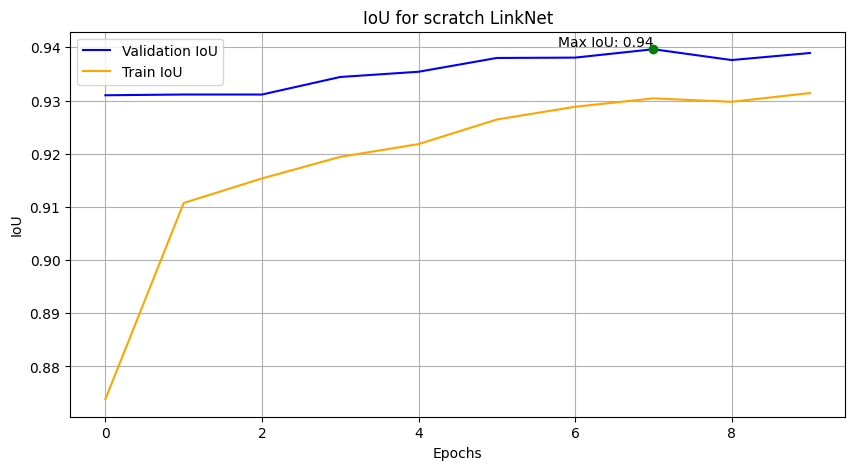

In [25]:
plot_metrics(metrics)